# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя.


## Загрузка данных

Импортируем все необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

"Прочитаем" файл и определим его размерность:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

print("Размер датасета:", labels.shape)

Размер датасета: (7591, 2)


Выведем первые пять строк на экран:

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.duplicated().sum()

0

In [9]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

**Вывод:** датасет содержит 7591 изображение, не имеет пропусков и дубликатов в классификации возраста изображенного человека и может быть дальше использован для реализации проекта.

## Исследовательский анализ данных

Визуализируем распределение возраста:

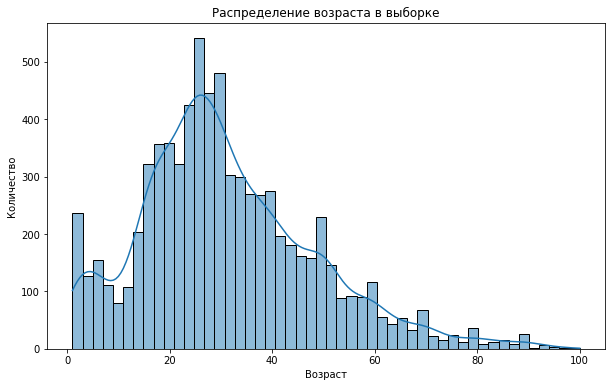

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=50, kde=True)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Из полученного графика видно, что распределение неравномерное. Наиболее часто встречается возраст 20-30 лет. Отмечается большее количество "целых" лет. 

Учитывая факты того, что определить возраст ребенка достаточно трудно и что дети чаще всего находятся в сопровождении взрослых, исключим из датасета снимки тех, у кого возраст меньше 7 лет:

In [6]:
labels = labels[labels['real_age'] > 7]
len(labels)

7006

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7006 validated image filenames.


Посмотрим, как выглядят снимки:

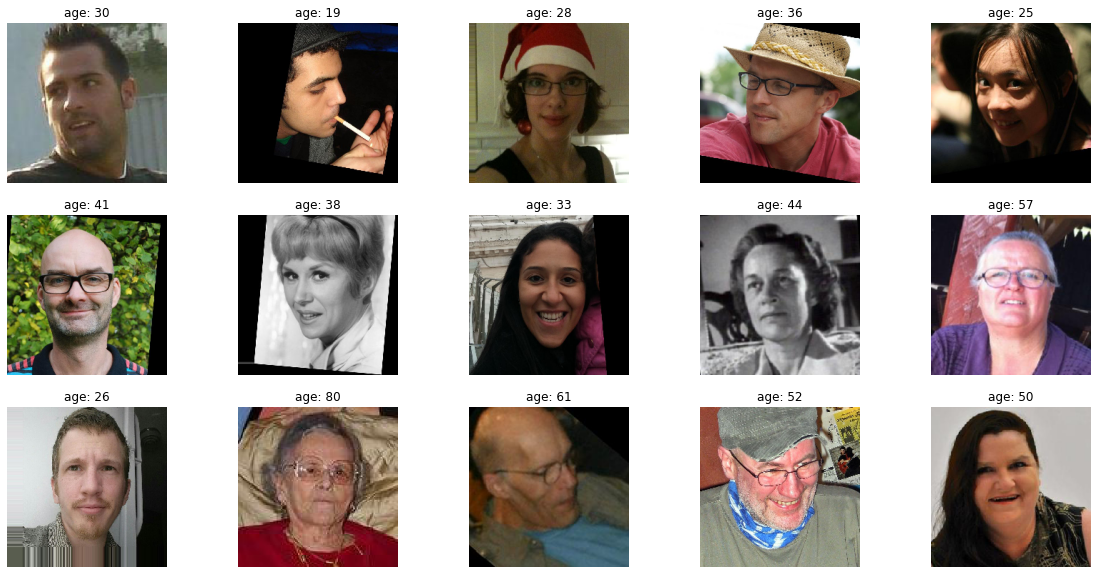

In [8]:
plt.figure(figsize=(20, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    batch = next(train_gen_flow)
    image = batch[0][0] 
    plt.imshow(image)
    plt.title(f'age: {batch[1][0]:.0f}')
    plt.axis('off')
plt.show()

**Вывод:** изображения квадратные, их размер 224*224 пикселя. Очень часто лицо человека располагается не в анфас, фото могут быть обрезанными, перевернутыми или размытыми, в связи с чем далее будет использован поворот. Также изображения могут быть не только цветными, но и черно-белыми.

## Обучение модели

Напишем 4 функции для того, чтобы запустить их на сервере:

```python

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')  
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True,
            brightness_range=(0.8, 1.))
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    optimizer = Adam(lr=0.0001)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)
    return model

```

После запуска на сервере был получен следующий результат:

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-07-28 15:05:01.734318: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-28 15:05:02.064149: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 61s - loss: 245.3717 - mae: 11.1677 - val_loss: 575.9072 - val_mae: 18.9528
Epoch 2/10
178/178 - 55s - loss: 77.2041 - mae: 6.5869 - val_loss: 628.6639 - val_mae: 19.9811
Epoch 3/10
178/178 - 55s - loss: 51.4608 - mae: 5.4012 - val_loss: 494.0795 - val_mae: 17.3205
Epoch 4/10
178/178 - 56s - loss: 37.0136 - mae: 4.6346 - val_loss: 112.6919 - val_mae: 8.0671
Epoch 5/10
178/178 - 56s - loss: 28.2262 - mae: 4.0234 - val_loss: 78.9617 - val_mae: 6.5892
Epoch 6/10
178/178 - 55s - loss: 20.8687 - mae: 3.5235 - val_loss: 72.0272 - val_mae: 6.3748
Epoch 7/10
178/178 - 56s - loss: 16.8451 - mae: 3.1661 - val_loss: 65.5453 - val_mae: 6.1034
Epoch 8/10
178/178 - 56s - loss: 14.2014 - mae: 2.8864 - val_loss: 70.1867 - val_mae: 6.3493
Epoch 9/10
178/178 - 56s - loss: 11.6012 - mae: 2.6183 - val_loss: 68.8497 - val_mae: 6.3329
Epoch 10/10
178/178 - 56s - loss: 10.5455 - mae: 2.4783 - val_loss: 61.9116 - val_mae: 5.9127
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 61.9116 - mae: 5.9127
Test MAE: 5.9127

```

## Анализ обученной модели

При построении модели была использована архитектура ResNet50, а также оптимизатор Adam со скоростью обучения 0.001. Для оценки модели была использована такая метрика, как среднеквадратичная ошибка.

Всего было 10 эпох и модель училась на 4 из них - далее происходило просто улучшение результата. 

Задача проекта - получить MAE меньше 8, еще лучше - меньше 7. Идеальный результат - 5,4. Минимальное требуемое значение было достигнуто уже на пятой эпохе, а итоговое значение метрики составило 5.9, что всего на половину (года) больше, чем идеальный результат. 

Получается, что в среднем модель ошибается в предсказании возраста на 6 лет, что делает невозможным ее применение для продажи алкоголя или табачных изделий. Однако такой результат является приемлемым для того, чтобы разработать систему рекомендаций и персонализировать предложения каждому клиенту.